### Importing the libraries:

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import InputLayer, Conv1D, Flatten, MaxPooling1D, UpSampling1D, Reshape
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle
import plotly.express as px

from numpy import mean
from numpy import std
from numpy import dstack
from keras.utils import to_categorical

 chenge this function to convert sequences which has 3 feature input and categorical_class as output


### function to create sequences:

In [ ]:
def to_sequences(df, seq_size=128, seq_stride=128, feature='CURRENT|6', y_type='wear_class', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    x2_values = []
    x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df['CURRENT|6']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])

    for index, data in enumerate(df['CURRENT|1']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x2_values.append(data[i:(i+seq_size)])

    for index, data in enumerate(df['CURRENT|2']):
      for i in range(0,len(data)-seq_size,seq_stride):
          x3_values.append(data[i:(i+seq_size)])

    
    if mix=='ON':
      x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly = shuffle(x1_values, x2_values, x3_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        'CURRENT|6':x1_values,
        'CURRENT|1':x2_values,
        'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values, x2_values, x3_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

In [ ]:
def to_sequences_1_feature(df, seq_size=128, seq_stride=128, y_type='wear_class', feature='CURRENT|6', mix='OFF', current_values='current_values', anomaly_or_not='anomaly_or_not'):
    #feature_cols = ['CURRENT|6', 'CURRENT|1', 'CURRENT|2']
    x1_values = []
    #x2_values = []
    #x3_values = []
    y_values = []
    file_index = []
    is_anomaly = []
    wear_class = []

    for index, data in enumerate(df[feature]):
      for i in range(0,len(data)-seq_size,seq_stride):
          x1_values.append(data[i:(i+seq_size)])
          #y_values.append(data[i+seq_size])
          file_index.append(df.iloc[index].file_no)
          is_anomaly.append(df.iloc[index][anomaly_or_not])
          wear_class.append(df.iloc[index]['wear_class'])
    
    if mix=='ON':
      x1_values, file_index, wear_class, is_anomaly = shuffle(x1_values, file_index, wear_class, is_anomaly, random_state=1)

    seq_df = pd.DataFrame({
        'file_no':file_index,
        'anomaly_or_not':is_anomaly,
        'wear_class': wear_class,
        feature:x1_values,
        #'CURRENT|1':x2_values,
        #'CURRENT|2':x3_values
    })
    if y_type == 'wear_class':
      y_values = wear_class
    elif y_type == anomaly_or_not:
      y_values = is_anomaly

    #x_list = list()
    #x_list.append(x1_values, x2_values, x3_values)
    x_3d = np.dstack([x1_values])
    x_array = x_3d #np.asarray(x_values).astype('float32')
    y_array = to_categorical(y_values)
    #x_array = np.reshape(x_array, (x_array.shape[0],x_array.shape[1],1))
    return seq_df, x_array, y_array

## Before Transfer Learning:

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

balanced_df = balanced_df[balanced_df.file_no.isin([5,6,7,8])] #1,2,3,4,9,10,11,12

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()

balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())

df_seq, X, y = to_sequences(balanced_df_list, 300, 300, mix='ON', y_type='is_anomaly', anomaly_or_not='is_anomaly') #,feature='CURRENT|6'
print(X.shape, y.shape)
print('----')
#print_anomaly_stats(df_seq, cur_val_col='CURRENT|6');
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count()) 

train_test_split = 0.8  # 80% test train split ratio
to_split_at = int(train_test_split*X.shape[0])
df_seq_train, X_train1, y_train1 = df_seq[:to_split_at], X[:to_split_at], y[:to_split_at]
print(X_train1.shape, y_train1.shape)
df_seq_test, X_test1, y_test1 = df_seq[to_split_at:], X[to_split_at:], y[to_split_at:]
print(X_test1.shape, y_test1.shape)
print('------')
df = df_seq_train.reset_index()
print('total_train_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')
df = df_seq_test.reset_index()
print('total_test_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())

trainX, trainy, testX, testy = X_train1, y_train1, X_test1, y_test1

verbose, epochs, batch_size = 1, 20, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(LSTM(64))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# fit network
model_history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose).history #, validation_split=0.1
# evaluate model
#_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)


(834, 300, 3) (834, 2)
----
total_sequences:  834
wear_class
0    423
1     76
2    168
3    167
Name: wear_class, dtype: int64
(667, 300, 3) (667, 2)
(167, 300, 3) (167, 2)
------
total_train_sequences:  667
wear_class
0    342
1     60
2    129
3    136
Name: wear_class, dtype: int64
------
total_test_sequences:  167
wear_class
0    81
1    16
2    39
3    31
Name: wear_class, dtype: int64
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 296, 64)           1024      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 148, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 146, 64)           12352     
                                                       

KeyError: ignored

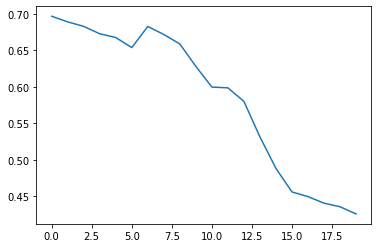

In [ ]:
plt.plot(model_history['loss'], label='Training loss');
plt.plot(model_history['val_loss'], label='Validation loss');
plt.legend()

KeyError: ignored

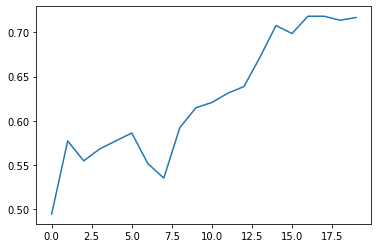

In [ ]:
plt.plot(model_history['accuracy'], label='Accuracy');
plt.plot(model_history['val_accuracy'], label='Validation Accuracy')
plt.legend()

21/21 [==============================] - 0s 10ms/step
[[196 146]
 [ 60 265]]
              precision    recall  f1-score   support

       False       0.77      0.57      0.66       342
        True       0.64      0.82      0.72       325

    accuracy                           0.69       667
   macro avg       0.71      0.69      0.69       667
weighted avg       0.71      0.69      0.69       667



<ipython-input-23-81a7b4054aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)


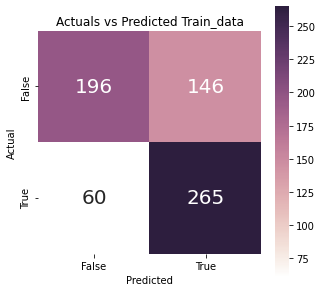

In [ ]:
trainPredict1 = model.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

6/6 [==============================] - 0s 11ms/step
[[39 42]
 [21 65]]
              precision    recall  f1-score   support

       False       0.65      0.48      0.55        81
        True       0.61      0.76      0.67        86

    accuracy                           0.62       167
   macro avg       0.63      0.62      0.61       167
weighted avg       0.63      0.62      0.62       167



<ipython-input-24-b10475e6199e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)


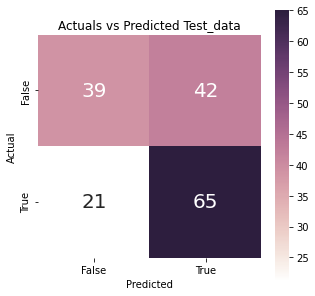

In [ ]:
testPredict1 = model.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

## After Transfer learning: 

In [ ]:
save_dir = '/content/drive/MyDrive/saved_model/'
this_model_name = 'base_model_1dCNN_tool_d12d20_300_10' #100_10_f5678_minMaxScl_1c_1l_3x_2y_tlwr_v1 #lstmAE_5lyr
  
base_model = tf.keras.models.load_model(save_dir+this_model_name)
base_model.trainable = False
base_model.summary()

x = Dense(50, activation='relu')(base_model.layers[-3].output)
o = Dense(n_outputs, activation='softmax')(x)
model_2 = Model(base_model.inputs,[o])
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 296, 64)           1024      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 148, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 146, 64)           12352     
                                                                 
 dropout_3 (Dropout)         (None, 146, 64)           0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 73, 64)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4672)             

In [ ]:
# fit network
model_2_history = model_2.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose).history #, validation_split=0.1
# evaluate model
#_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, validation_split=0.1, verbose=1)

Epoch 1/20
21/21 [==============================] - 1s 12ms/step - loss: 0.6540 - accuracy: 0.7211
Epoch 2/20
21/21 [==============================] - 0s 12ms/step - loss: 0.6247 - accuracy: 0.7811
Epoch 3/20
21/21 [==============================] - 0s 11ms/step - loss: 0.6019 - accuracy: 0.7601
Epoch 4/20
21/21 [==============================] - 0s 11ms/step - loss: 0.5766 - accuracy: 0.7646
Epoch 5/20
21/21 [==============================] - 0s 12ms/step - loss: 0.5517 - accuracy: 0.7586
Epoch 6/20
21/21 [==============================] - 0s 12ms/step - loss: 0.5304 - accuracy: 0.7631
Epoch 7/20
21/21 [==============================] - 0s 11ms/step - loss: 0.5111 - accuracy: 0.7646
Epoch 8/20
21/21 [==============================] - 0s 12ms/step - loss: 0.4985 - accuracy: 0.7661
Epoch 9/20
21/21 [==============================] - 0s 12ms/step - loss: 0.4811 - accuracy: 0.7856
Epoch 10/20
21/21 [==============================] - 0s 12ms/step - loss: 0.4646 - accuracy: 0.7811
Epoch 11/

KeyError: ignored

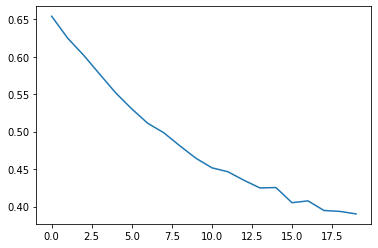

In [ ]:
plt.plot(model_2_history['loss'], label='Training loss');
plt.plot(model_2_history['val_loss'], label='Validation loss')
plt.legend()

KeyError: ignored

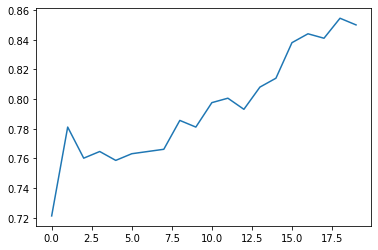

In [ ]:
plt.plot(model_2_history['accuracy'], label='Accuracy');
plt.plot(model_2_history['val_accuracy'], label='Validation Accuracy');
plt.legend()

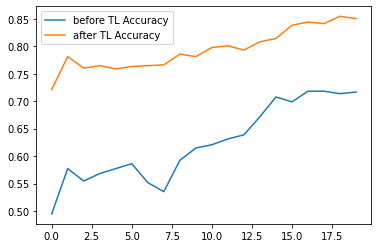

In [ ]:
plt.plot(model_history['accuracy'], label='before TL Accuracy');
plt.plot(model_2_history['accuracy'], label='after TL Accuracy');
plt.legend()

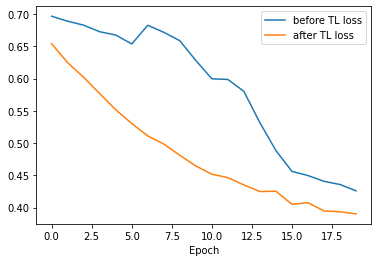

In [ ]:
plt.plot(model_history['loss'], label='before TL loss');
plt.plot(model_2_history['loss'], label='after TL loss');
plt.xlabel("Epoch")
plt.legend()

21/21 [==============================] - 0s 7ms/step
[[325  17]
 [ 78 247]]
              precision    recall  f1-score   support

       False       0.81      0.95      0.87       342
        True       0.94      0.76      0.84       325

    accuracy                           0.86       667
   macro avg       0.87      0.86      0.86       667
weighted avg       0.87      0.86      0.86       667



<ipython-input-31-5171e3ab40da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)


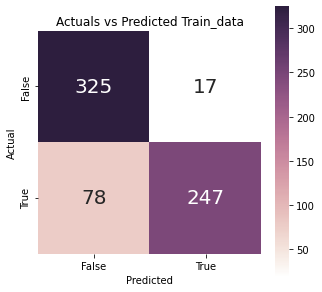

In [ ]:
trainPredict1 = model_2.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

6/6 [==============================] - 0s 7ms/step
[[72  9]
 [17 69]]
              precision    recall  f1-score   support

       False       0.81      0.89      0.85        81
        True       0.88      0.80      0.84        86

    accuracy                           0.84       167
   macro avg       0.85      0.85      0.84       167
weighted avg       0.85      0.84      0.84       167



<ipython-input-32-294564f54e3e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)


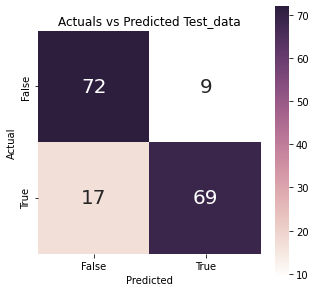

In [ ]:
testPredict1 = model_2.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()

## Creating Base Model and training it with augmented data of Tool1 and Tool3:

In [ ]:
balanced_df = pd.read_csv('/content/drive/MyDrive/wbk/tool_wear_data/balanced_tool_wear_current_data.csv', 
                          dtype={'file_no':int, 'tool':int, 'tool_diameter':int, 'damage_teeth':str, 'wear_class':int, 'is_anomaly':bool})

balanced_df = balanced_df[balanced_df.file_no.isin([1,2,3,4,9,10,11,12])] #1,2,3,4,9,10,11,12

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6' ]].to_numpy())
balanced_df[['CURRENT|1', 'CURRENT|2','CURRENT|6']] = df_scaled.tolist()
balanced_df_list = (balanced_df.groupby(['file_no','tool', 'tool_diameter','damage_teeth','is_anomaly','wear_class']).
                    agg({'CURRENT|6': lambda x: x.tolist(),'CURRENT|1': lambda y: y.tolist(),'CURRENT|2': lambda z: z.tolist()}).
                    reset_index())

df_seq, X, y = to_sequences(balanced_df_list, 300, 10, mix='ON',feature='CURRENT|6', y_type='is_anomaly', anomaly_or_not='is_anomaly')
print(X.shape, y.shape)
print('----')
#print_anomaly_stats(df_seq, cur_val_col='CURRENT|6');
df = df_seq.reset_index()
print('total_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count()) 

train_test_split = 0.8  # 80% test train split ratio
to_split_at = int(train_test_split*X.shape[0])
df_seq_train, X_train1, y_train1 = df_seq[:to_split_at], X[:to_split_at], y[:to_split_at]
print(X_train1.shape, y_train1.shape)
df_seq_test, X_test1, y_test1 = df_seq[to_split_at:], X[to_split_at:], y[to_split_at:]
print(X_test1.shape, y_test1.shape)
print('------')
df = df_seq_train.reset_index()
print('total_train_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())
print('------')
df = df_seq_test.reset_index()
print('total_test_sequences: ',df.groupby('index').size().count())
print(df.groupby(['index', 'wear_class'])['wear_class'].count().groupby('wear_class').count())

load_model = 0
train_model = 1
save_dir = '/content/drive/MyDrive/saved_model/'
this_model_name = 'base_model_1dCNN_tool_d12d20_300_10' #100_10_f5678_minMaxScl_1c_1l_3x_2y_tlwr_v1 #lstmAE_5lyr
if load_model == 1:
  # Loads the weights
  #lstm_autoencoder_history = lstm_autoencoder.load_weights(checkpoint_path)
  model = tf.keras.models.load_model(save_dir+this_model_name)

trainX, trainy, testX, testy = X_train1, y_train1, X_test1, y_test1
verbose, epochs, batch_size = 1, 20, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(MaxPooling1D())
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
#model.add(LSTM(64))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# fit network
model_history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1).history
# evaluate model
#_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)

if train_model==1:
  model.save(save_dir+this_model_name);

(52170, 300, 3) (52170, 2)
----
total_sequences:  52170
wear_class
0    25904
1     5142
2    10538
3    10586
Name: wear_class, dtype: int64
(41736, 300, 3) (41736, 2)
(10434, 300, 3) (10434, 2)
------
total_train_sequences:  41736
wear_class
0    20711
1     4104
2     8450
3     8471
Name: wear_class, dtype: int64
------
total_test_sequences:  10434
wear_class
0    5193
1    1038
2    2088
3    2115
Name: wear_class, dtype: int64
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 296, 64)           1024      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 148, 64)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 146, 64)           12352     
             

In [ ]:
plt.plot(model_history['loss'], label='Training loss');
plt.plot(model_history['val_loss'], label='Validation loss');
plt.legend()

In [ ]:
plt.plot(model_history['accuracy'], label='Accuracy');
plt.plot(model_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

![image.png]()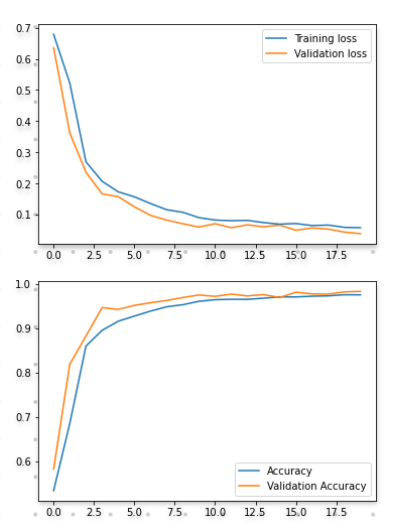

1305/1305 [==============================] - 11s 9ms/step


<ipython-input-43-81a7b4054aec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)


[[20304   407]
 [  242 20783]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.98     20711
        True       0.98      0.99      0.98     21025

    accuracy                           0.98     41736
   macro avg       0.98      0.98      0.98     41736
weighted avg       0.98      0.98      0.98     41736



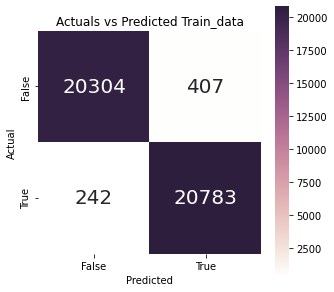

In [ ]:
trainPredict1 = model.predict(X_train1)
df_seq_train['pred']  = np.argmax(trainPredict1, axis=1)
org = df_seq_train.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_train.pred

data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Train_data')
plt.show()

327/327 [==============================] - 3s 9ms/step


<ipython-input-44-b10475e6199e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seq_test['pred']  = np.argmax(testPredict1, axis=1)


[[5082  111]
 [  80 5161]]
              precision    recall  f1-score   support

       False       0.98      0.98      0.98      5193
        True       0.98      0.98      0.98      5241

    accuracy                           0.98     10434
   macro avg       0.98      0.98      0.98     10434
weighted avg       0.98      0.98      0.98     10434



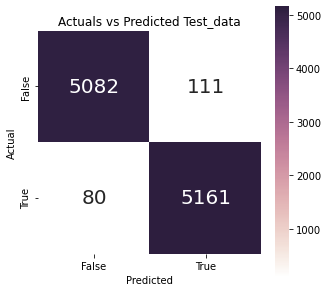

In [ ]:
testPredict1 = model.predict(X_test1)
df_seq_test['pred']  = np.argmax(testPredict1, axis=1)
org = df_seq_test.anomaly_or_not #df_seq_train.wear_class
pred = df_seq_test.pred
data = confusion_matrix(org,pred)
print(data)
print(classification_report(org, pred))

df_cm = pd.DataFrame(data, columns=np.unique(org), index = np.unique(org))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)

sns.heatmap(df_cm, cbar=True, annot=True, cmap=cmap, square=True, fmt='.0f',
            annot_kws={'size': 20})
plt.title('Actuals vs Predicted Test_data')
plt.show()